In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.metrics import normalized_mutual_info_score as nmis
from sklearn.metrics import adjusted_mutual_info_score as amis
from sklearn.decomposition import PCA

import importlib # so that I can reload my modules without restarting the kernel while developing them
from cytof_io import cd, get_metals
from vis_correction import plot_cluster_medians, PCA_vis
from BarcodingError import BarcodingError, BarcodingErrorSample, BarcodingErrorKMeans

In [22]:
df_pre = pd.read_csv("Pre_stain_all_clustered.Q_0.91.csv", index_col=0).fillna(-1) 
df_ind = pd.read_csv("C1_and_CA_rawQ_0.91_clustered.csv", index_col=0).fillna(-1)
df_post = pd.read_csv("Post_stain_C1_clustered.Q_0.885.csv", index_col=0).fillna(-1)

#.fillna(-1), In case outliers are labelled as NaN

In [23]:
df_pre_C1 = df_pre[df_pre["C1"] == True] # 106 vs 104 - the class_ column will be "S"
df_pre_CA = df_pre[df_pre["C1"] == False] #110 vs 108 - the class_ column will be "S"

df_pre_S = df_pre[df_pre["S"] == True] # 110 vs 106 - the class_ column will be "C1"
df_pre_U = df_pre[df_pre["S"] == False] # 108 vs 104 - the class_ column will be "C1"

In [24]:
df_ind_C1 = df_ind[df_ind["C1"] == True] # compare stimulated vs unstimulated in C1
df_ind_CA = df_ind[df_ind["C1"] == False] # compare stimulated vs unstimulated in CA

df_ind_S = df_ind[df_ind["S"] == True] # compare C1 vs CA in stimulated
df_ind_U = df_ind[df_ind["S"] == False] # compare C1 vs CA in unstimulated

In [25]:
df_post_C1 = df_post[df_post["C1"] == True] 
# compare stimulated vs unstimulated in C1, the only ones with enough cells in mixed post staining

In [26]:
metals = get_metals(list(df_pre))[-1]
barcodes = ["104Pd_CD45_C1_Unstim", "106Pd_CD45_C1_Stim", "108Pd_CD45_CA_nstim", "110Pd_CD45"]

In [27]:
bc_dict = {104:'104Pd_CD45_C1_Unstim',
           106: '106Pd_CD45_C1_Stim',
           108: '108Pd_CD45_CA_nstim',
           110: '110Pd_CD45'}

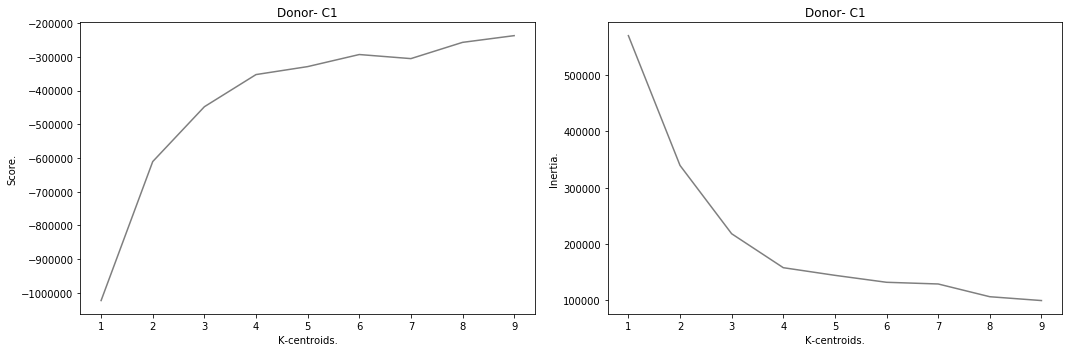

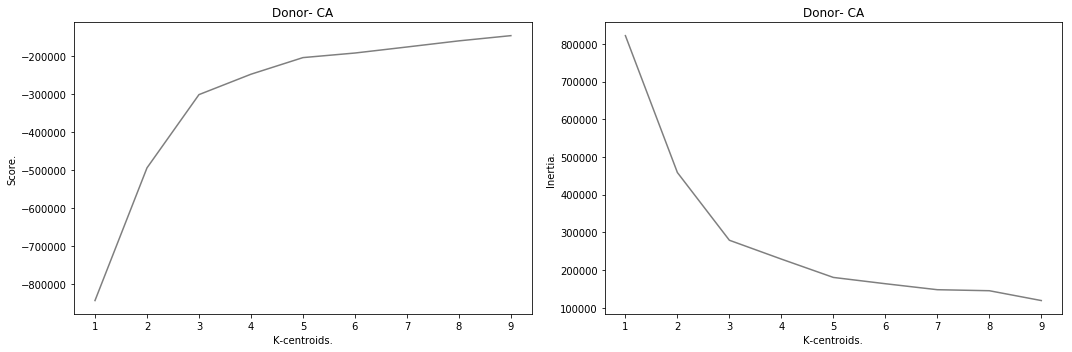

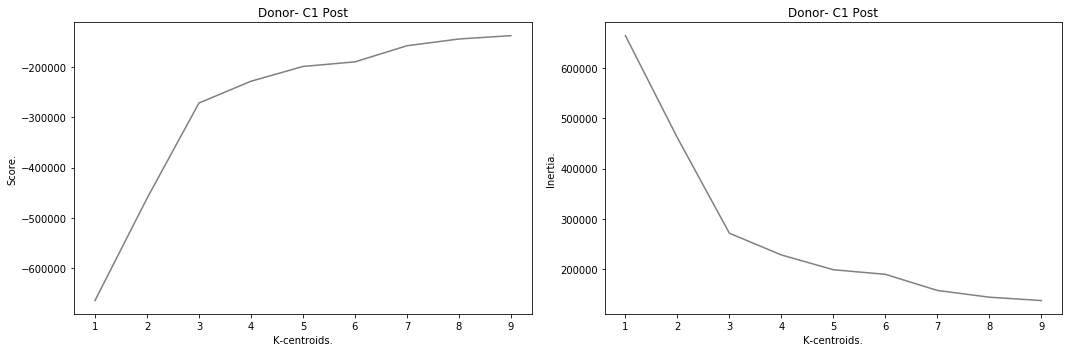

In [8]:
cluster_markers = ['141Pr_CD49d', '145Nd_CD4', '154Sm_CD3', '157Gd_TNFa', '160Gd_IFNg']

Ks = list(range(1, 10))

def elbow_plot(df1, df2, cluster_markers, title, Ks):
    km = [KMeans(n_clusters=i) for i in Ks]
    score = [km_.fit(df1[cluster_markers]).score(df2[cluster_markers]) for km_ in km]
    inertias = [_.inertia_ for _ in km]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax1.plot(Ks, score, color="tab:gray")
    ax1.set_xlabel("K-centroids.")
    ax1.set_ylabel("Score.")
    ax1.set_title(title)

    ax2.plot(Ks, inertias, color="tab:gray")
    ax2.set_xlabel("K-centroids.")
    ax2.set_ylabel("Inertia.")
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()
    return inertias, score

C1_stats = elbow_plot(df_ind_C1, df_pre_C1, cluster_markers, "Donor- C1", Ks)
CA_stats = elbow_plot(df_ind_CA, df_pre_CA, cluster_markers, "Donor- CA", Ks)
C1_post_stats = elbow_plot(df_post_C1, df_post_C1, cluster_markers, "Donor- C1 Post", Ks)

In [9]:
other_barcodes = ["108Pd_CD45_CA_nstim", "110Pd_CD45"]
error_C1_pre = BarcodingError(df_pre_C1, class_="S", labels=metals, barcode1="104Pd_CD45_C1_Unstim", barcode2="106Pd_CD45_C1_Stim", other_barcodes=other_barcodes)
error_C1_ind = BarcodingError(df_ind_C1, class_="S", labels=metals, barcode1="104Pd_CD45_C1_Unstim", barcode2="106Pd_CD45_C1_Stim", other_barcodes=other_barcodes)
error_C1_post = BarcodingError(df_post_C1, class_="S", labels=metals, barcode1="104Pd_CD45_C1_Unstim", barcode2="106Pd_CD45_C1_Stim", other_barcodes=other_barcodes)

In [10]:
cluster_markers = ['141Pr_CD49d', '145Nd_CD4', '154Sm_CD3', '157Gd_TNFa', '160Gd_IFNg']

In [11]:
def PCA_wrong_correct(df1, df2, cols, colors=["tab:gray", "r"], 
                      title="PCA plot", show=True, save=False, **kwargs):
    """
    df1 = correct cells
    df2 = "wrong" cells

    """
    df = df1.append(df2, ignore_index=True)
    pca = PCA(n_components=2)
    trans = pca.fit_transform(df[cols].values)
    indices_df1 = list(range(0, len(df1)))
    indices_df2 = list(range(len(df1), len(df)))
    plot_indices = lambda ids, i, s, alpha: plt.scatter(
                x=trans[ids, 0], y=trans[ids, 1],
                color=colors[i], s=s, **kwargs)

    plot_indices(indices_df1, 0, 2, 0.1)
    plot_indices(indices_df2, 1, 2, 0.1)
    explained_variance = pca.explained_variance_ratio_[:2]
    title += ".    Explained variance: " + str( round( sum( explained_variance ), 2) ) + "."
    xlabel = ("PC1: " + str( round(explained_variance[0], 2) ) )
    ylabel = ("PC2: " + str( round(explained_variance[1], 2) ) )
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    if show:plt.show()
    if save:plt.savefig(title)
    return pca, trans

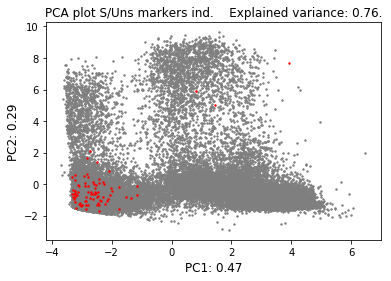

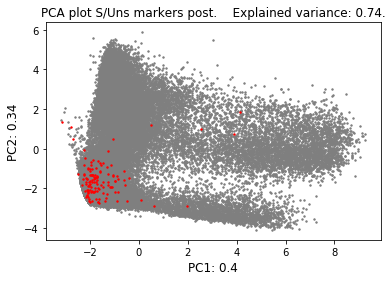

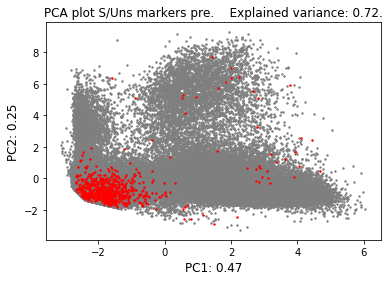

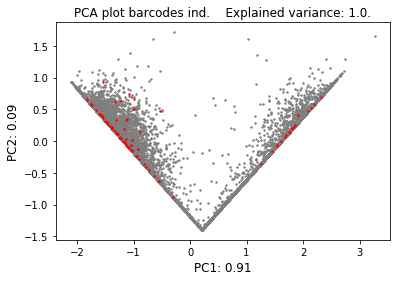

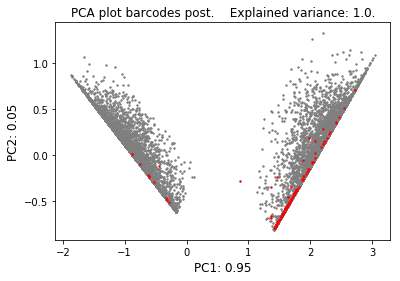

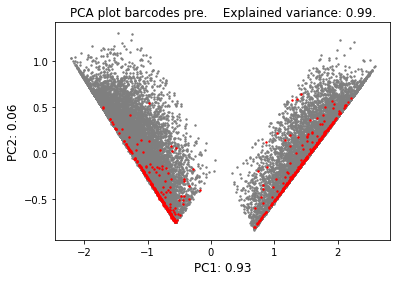

In [12]:
pca, trans = PCA_wrong_correct(error_C1_ind.correct, error_C1_ind.swapped, cluster_markers, title="PCA plot S/Uns markers ind")
pca, trans = PCA_wrong_correct(error_C1_post.correct, error_C1_post.swapped, cluster_markers, title="PCA plot S/Uns markers post")
pca, trans = PCA_wrong_correct(error_C1_pre.correct, error_C1_pre.swapped, cluster_markers, title="PCA plot S/Uns markers pre")

pca, trans = PCA_wrong_correct(error_C1_ind.correct, error_C1_ind.swapped, barcodes, title="PCA plot barcodes ind")
pca, trans = PCA_wrong_correct(error_C1_post.correct, error_C1_post.swapped, barcodes, title="PCA plot barcodes post")
pca, trans = PCA_wrong_correct(error_C1_pre.correct, error_C1_pre.swapped, barcodes, title="PCA plot barcodes pre")

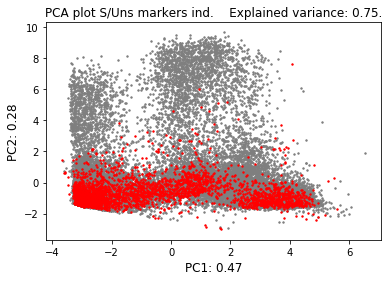

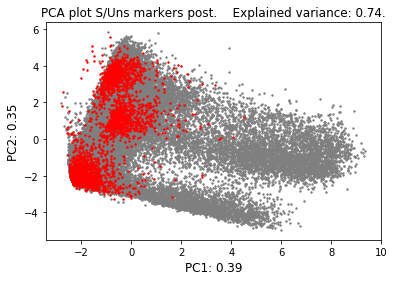

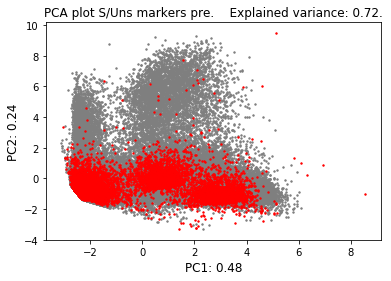

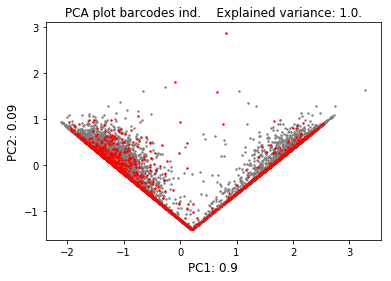

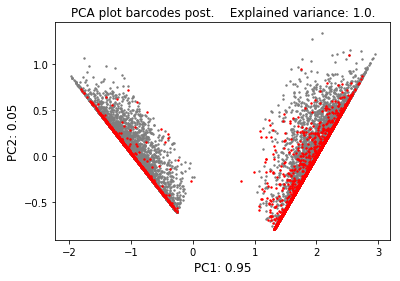

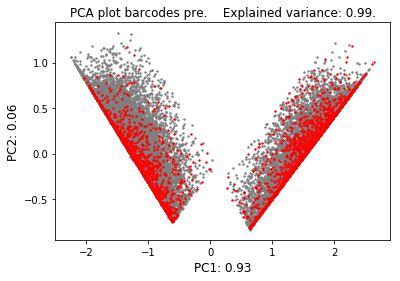

In [13]:
pca, trans = PCA_wrong_correct(error_C1_ind.correct, error_C1_ind.wrong, cluster_markers, title="PCA plot S/Uns markers ind")
pca, trans = PCA_wrong_correct(error_C1_post.correct, error_C1_post.wrong, cluster_markers, title="PCA plot S/Uns markers post")
pca, trans = PCA_wrong_correct(error_C1_pre.correct, error_C1_pre.wrong, cluster_markers, title="PCA plot S/Uns markers pre")

pca, trans = PCA_wrong_correct(error_C1_ind.correct, error_C1_ind.wrong, barcodes, title="PCA plot barcodes ind")
pca, trans = PCA_wrong_correct(error_C1_post.correct, error_C1_post.wrong, barcodes, title="PCA plot barcodes post")
pca, trans = PCA_wrong_correct(error_C1_pre.correct, error_C1_pre.wrong, barcodes, title="PCA plot barcodes pre")

In [28]:
def list_cluster_sizes(list_of_series):
    return list(pd.DataFrame([i.sum(axis=1) for i in list_of_series]).values.flatten())

def row_wise_normalize(df):
    return df.div(df.sum(axis=1), axis='index')

def SampleControlClusterPurity(df_control=None, df_sample=None, sample=None, samples=None, dfs_samples=None,
                               control=None, N=100, K=4, **kwargs):

    # pass 1 control and two samples: do an RFC on all separately,
    #      intersect the labels, cluster the control, then pass

    if type(df_sample) != type(None):
        dfs_samples = [df_sample]

    control_cluster_sizes = []

    n_samples = len(dfs_samples)
    
    labels_control = []
    average_purity_sample = []
    sample_ratios_list = []
    sample_cluster_sizes = []
    labels_sample = []

    if samples == None:
        assert type(dfs_samples) != type(None)
        samples = [BarcodingErrorSample(df_sample, **kwargs) for df_sample in dfs_samples]

    if control == None:
        assert type(df_control) != type(None)
        control = BarcodingErrorKMeans(df_control, **kwargs)
    
    control.intersect_labels(samples)

    control.set_simulation_results(K, [], [], [], [])
    sample_cluster_sizes_list = []
    for sample in samples:
        sample.set_simulation_results(K, [], [], [], [])
        sample_cluster_sizes_list.append([])

    get_results = lambda obj: obj.simulation_results[K]
    control_results = get_results(control)

    iter_samples = list(zip(samples, sample_cluster_sizes_list))
    for i in range(N):
        # do bootstrapping, since std(average_purity) ~ 0
        # How simulation results are stored:
        # average_purity ratios_list cluster_sizes labels

        control.analyse(K=K, i=i);

        control_counts = control.counts_per_condition
        control_cluster_sizes.append(control_counts)

        control_ratios = row_wise_normalize(control_counts)
        control_results.ratios_list.append(control_ratios)
        control_results.average_purity.append(
            control_ratios.max(axis=1).mean() )

        control_results.labels.append(control.KMeans_labels)

        for sample, sample_cluster_sizes in iter_samples:
            # How simulation results are stored:
            # average_purity ratios_list cluster_sizes labels
            sample.analyse(K=K, control=control, i=i,
                                       init=control.cluster_centers_)
            sample_results = get_results(sample)
            sample_counts = sample.counts_per_condition

            sample_ratios = row_wise_normalize(sample_counts)

            sample_results.average_purity.append(
                sample_ratios.max(axis=1).mean() )

            sample_results.ratios_list.append(sample_ratios)

            sample_cluster_sizes.append(sample_counts)
            sample_results.labels.append(sample.KMeans_labels)
    
    control_results.cluster_sizes.extend(list_cluster_sizes(control_cluster_sizes))
    for sample, sample_cluster_sizes in iter_samples:
        sample_results = get_results(sample)
        sample_results.cluster_sizes.extend(list_cluster_sizes(sample_cluster_sizes))

    return (control, samples)

def eval_labels(metric, labels_list):

    for labels in labels_list:
        metrices = []
        c1 = labels[-1]
        for c2 in labels[:-1]:
            metrices.append(metric(c1, c2))

        yield metrices

def plot_or_save(save, show, title):
    plt.title(title)
    if save:
        plt.savefig(title)
    if show:
        plt.show()

def analyse_sample_control(df_sample, df_control, K=3, N=100, bins=20,
                               class_="S", labels=metals, barcode1="104Pd_CD45_C1_Unstim", 
                               barcode2="106Pd_CD45_C1_Stim", save=False, show=True,
                              sample=None, control=None, name="comparison"):

    (control_obj, sample_obj) = SampleControlClusterPurity(df_sample=df_sample, df_control=df_control, K=K, N=N, 
                                           class_=class_, labels=labels, barcode1=barcode1, barcode2=barcode2,
                                           sample=sample, control=control)
    sample_obj = sample_obj[0]
    sample = sample_obj.simulation_results[K]
    control = control_obj.simulation_results[K]
    means = []
    for nmis_list, col, label in zip(eval_labels(nmis,
                                [sample.labels, control.labels]),
                                ["tab:gray",      "tab:cyan"],
                                ["Sample.",       "Control."]):
        plt.hist(nmis_list, bins=bins, color=col, label=label, alpha=0.5)
        means.append(np.mean(nmis_list))
    
    plt.xlabel("Nmis score. {} bins.".format(bins))
    plt.ylabel("Count of bins.")
    title = "NMIS scores."
    plot_or_save(save, show, title)

    plt.hist(sample.average_purity, bins=bins, color="tab:gray", label="Sample.", alpha=0.5)
    plt.hist(control.average_purity, bins=bins, color="tab:cyan", label="Control.", alpha=0.5)
    plt.xlabel("Average cluster purity. {} bins.".format(bins))
    plt.ylabel("Count.")
    plt.legend()
    title = "Cluster purities."
    plot_or_save(save, show, title)

    plt.hist(sample.cluster_sizes, bins=bins, color="tab:gray", alpha=0.5)
    plt.xlabel("Cluster cell count sample. {} bins.".format(bins))
    plt.ylabel("Count of bins.")
    title = "K={}. nmis:{}. Sample.".format(K, round(means[0], 2))
    plot_or_save(save, show, title)

    plt.hist(control.cluster_sizes, bins=bins, color="tab:gray", alpha=0.5)
    plt.xlabel("Cluster cell count control. {} bins.".format(bins))
    plt.ylabel("Count of bins.")
    title = "K={}. nmis:{}. Control.".format(K, round(means[1], 2))
    plot_or_save(save, show, title)
    
    if show:file_ = None
    elif save:
        file_ = open(name + "K:" + str(K) + ";" + "N:" + str(N) + ". PurityDifference.", "w")
    print("Difference in Means:", round(np.mean(sample.average_purity) - np.mean(control.average_purity), 2), file=file_)
    
    if save: file_.close()
    return sample_obj, control_obj

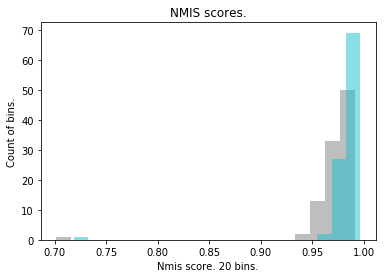

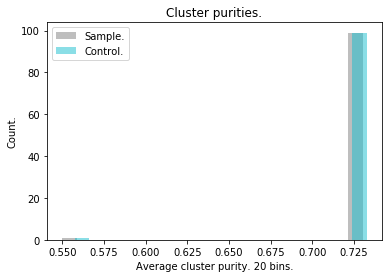

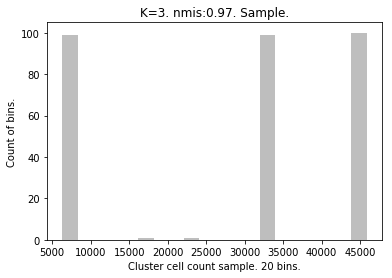

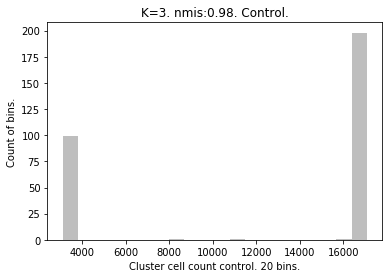

Difference in Means: -0.0


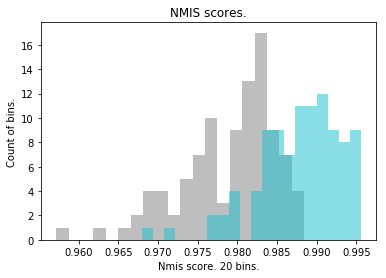

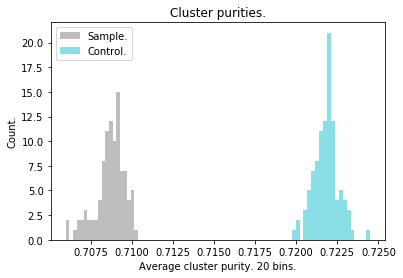

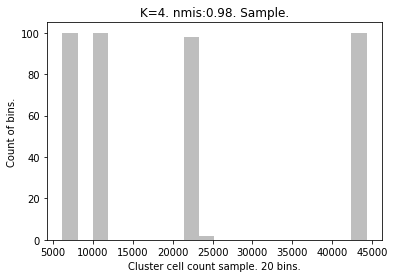

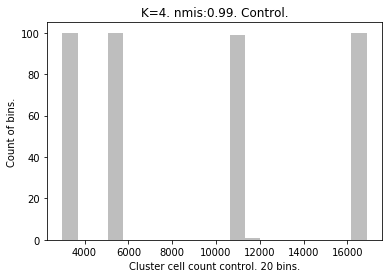

Difference in Means: -0.01


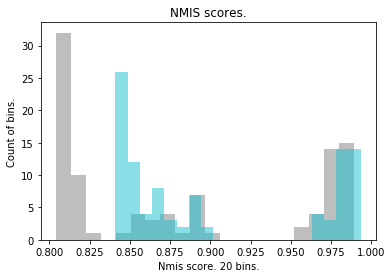

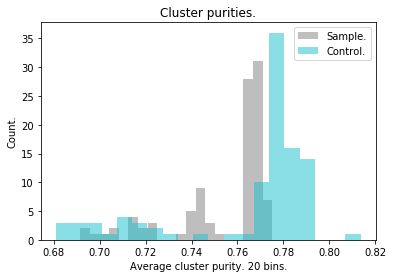

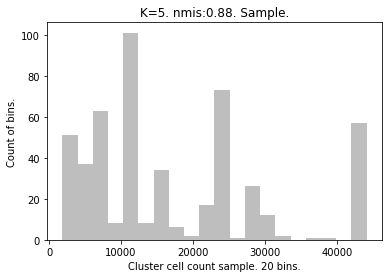

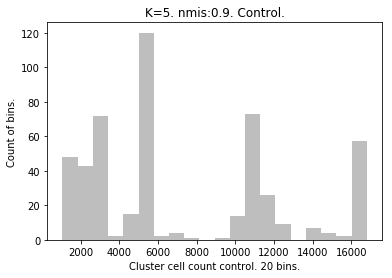

Difference in Means: -0.01


In [10]:
for k in [3, 4, 5]:
    analyse_sample_control(df_pre_C1, df_ind_C1, N=100, K=k, class_="S", labels=metals,
                                  barcode1="104Pd_CD45_C1_Unstim", barcode2="106Pd_CD45_C1_Stim")

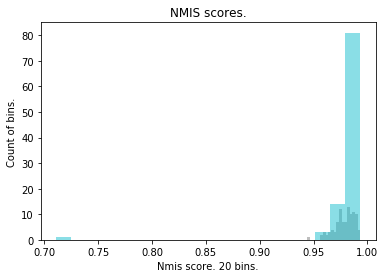

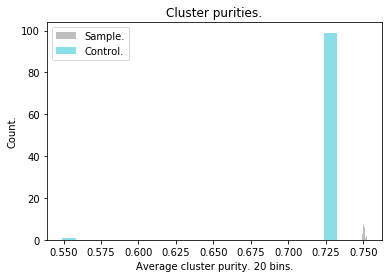

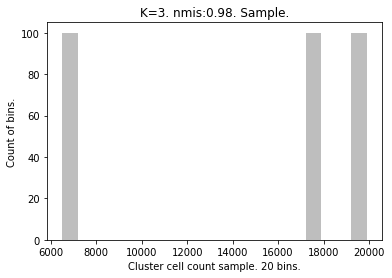

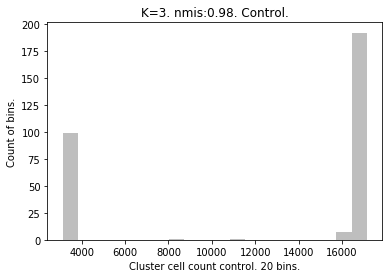

Difference in Means: 0.02


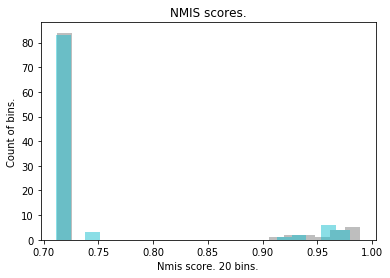

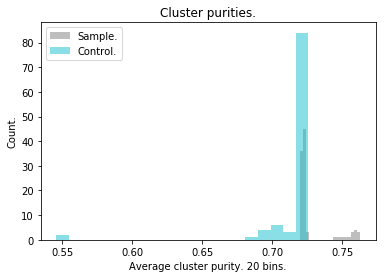

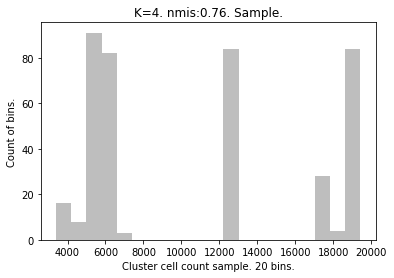

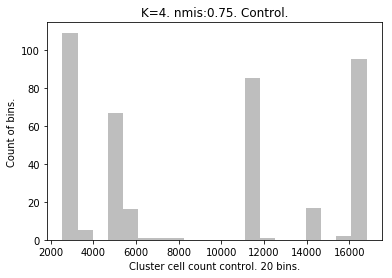

Difference in Means: 0.01


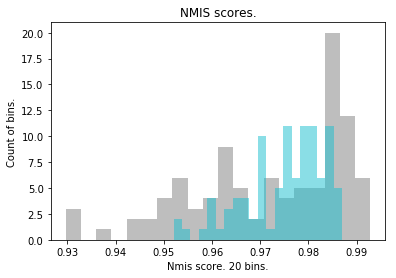

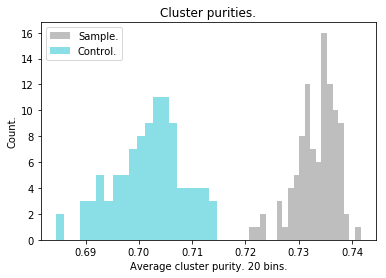

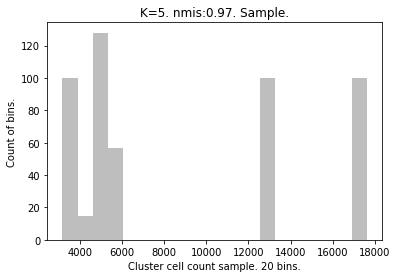

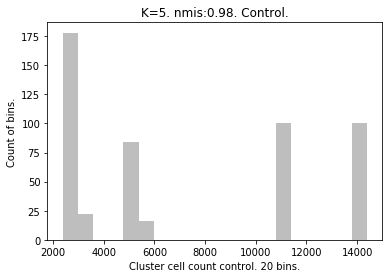

Difference in Means: 0.03


In [11]:
for k in [3, 4, 5]:
    analyse_sample_control(df_post_C1, df_ind_C1, N=100, K=k, class_="S", labels=metals,
                                  barcode1="104Pd_CD45_C1_Unstim", barcode2="106Pd_CD45_C1_Stim")

In [29]:
def analyse_samples_control(dfs_samples, df_control, K=3, N=100, bins=20,
                            class_="S", labels=metals, barcode1="104Pd_CD45_C1_Unstim", 
                            barcode2="106Pd_CD45_C1_Stim", save=False, show=True, 
                            names=["Control.", "Mixed Before Staining.", "Mixed After Staining."],
                            colors=["tab:cyan", "tab:gray", "tab:olive"],
                            fname="comparison"):

    (control_obj, sample_obj) = SampleControlClusterPurity(dfs_samples=dfs_samples, df_control=df_control, K=K, N=N, 
                                           class_=class_, labels=labels, barcode1=barcode1, barcode2=barcode2,
                                           )

    samples = [sample.simulation_results[K] for sample in sample_obj]
    control = control_obj.simulation_results[K]
    all_ = [control] + samples
    # Normalized Mutual Information Score Histogram
    
    means = []
    labels_lists = [_.labels for _ in all_]

    for nmis_list, col, label in zip(eval_labels(nmis, # the Normalized Mutual Information Score metric
                                labels_lists), colors, names):

        plt.hist(nmis_list, bins=bins, color=col, label=label, alpha=0.5)
        means.append(np.mean(nmis_list))
    
    plt.xlabel("Nmis score. {} bins.".format(bins))
    plt.ylabel("Count of bins.")
    title = "NMIS scores."
    plt.legend()
    plot_or_save(save, show, title)
    
    # Average Cluster Purity Histogram
    iter_samples = list(zip(all_, colors, names))
    for sample, color, name in iter_samples:
        plt.hist(sample.average_purity, bins=bins, color=color, label=name, alpha=0.5)
    plt.xlabel("Average cluster purity. {} bins.".format(bins))
    plt.ylabel("Count.")
    plt.legend()
    title = "Cluster purities."
    plot_or_save(save, show, title)
    
    # Cluster Cell Count Histograms.
    for sample, color, name in iter_samples:
        plt.hist(sample.cluster_sizes, bins=bins, color=color, alpha=0.5)
        plt.xlabel("Cluster cell count. {} bins.".format(bins))
        plt.ylabel("Count of bins.")
        title = "Cluster cell counts. K={}. nmis:{}. {}".format(K, round(means[0], 2), name)
        plot_or_save(save, show, title)
    
    if show:file_ = None
    elif save:
        file_ = open(fname + "K:" + str(K) + ";" + "N:" + str(N) + ". PurityDifference.", "w")
    # Difference in means from control
    sample_names = names[1:]
    for sample, name in zip(samples, sample_names): 
        print("Difference in Means {}:".format(name), round(np.mean(sample.average_purity) - np.mean(control.average_purity), 2), file=file_)
    
    if save: file_.close()
    return sample_obj, control_obj

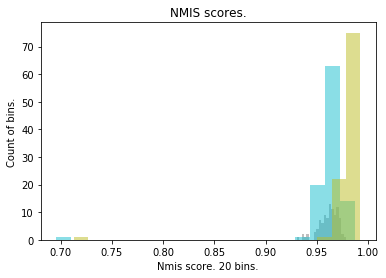

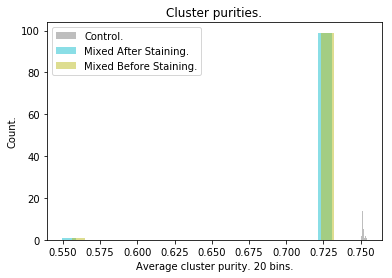

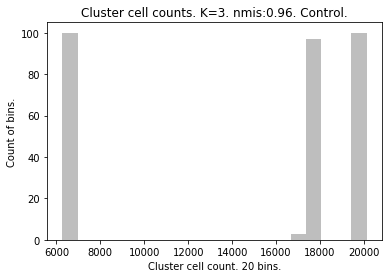

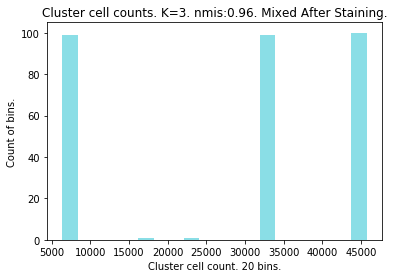

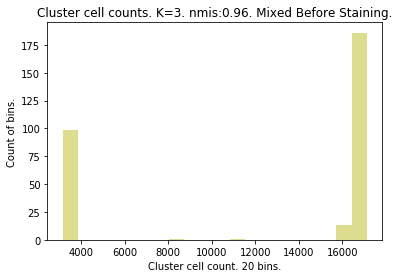

Difference in Means Mixed After Staining.: 0.02
Difference in Means Mixed Before Staining.: -0.0


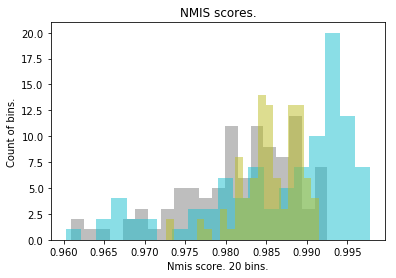

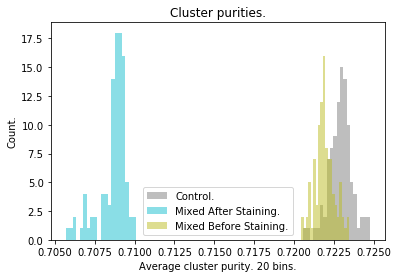

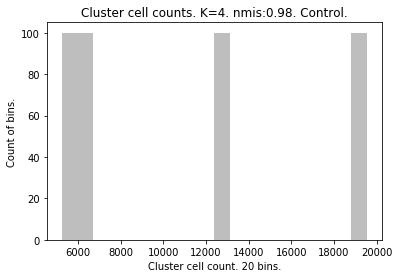

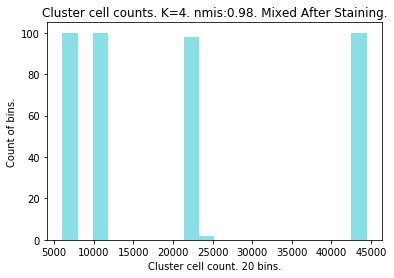

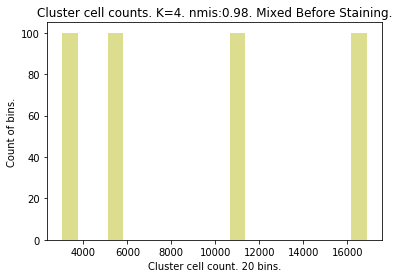

Difference in Means Mixed After Staining.: 0.0
Difference in Means Mixed Before Staining.: -0.01


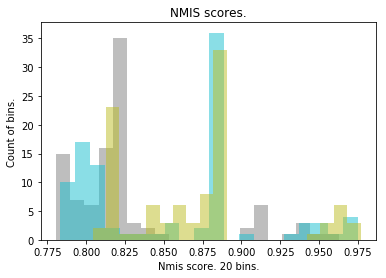

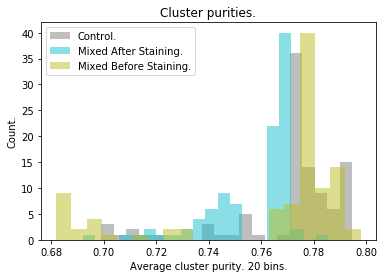

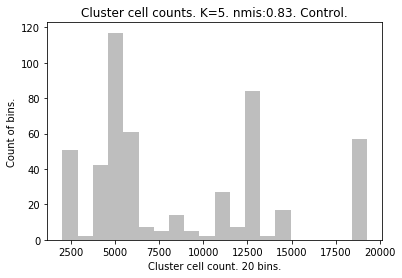

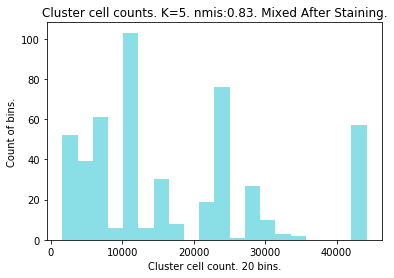

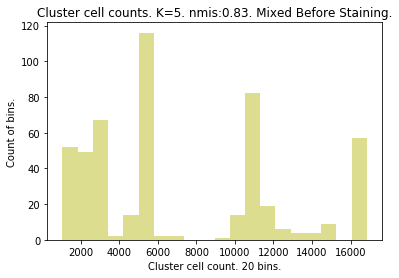

Difference in Means Mixed After Staining.: 0.01
Difference in Means Mixed Before Staining.: -0.0


In [34]:
sample_objs, control_objs = [], []
for k in [3, 4, 5]:
    s, c = analyse_samples_control(dfs_samples=[df_post_C1, df_pre_C1], df_control=df_ind_C1,
                            names=["Control.", "Mixed After Staining.", "Mixed Before Staining."],
                            K=k, N=100, class_="S", labels=metals,
                            colors=["tab:gray", "tab:cyan", "tab:olive"],
                            barcode1="104Pd_CD45_C1_Unstim", barcode2="106Pd_CD45_C1_Stim")
    sample_objs.append(s)
    control_objs.append(c)


In [35]:
dfs = df_post_C1, df_pre_C1, df_ind_C1


In [39]:
[df["S"].mean() for df in dfs]

[0.6817808968282902, 0.45074899996480816, 0.45232961214073203]

In [40]:
[len(df) for df in dfs]

[43888, 85247, 36637]